# Generative Adversarial Network for ECG synthesis
This notebook is an addition to this [notebook](https://www.kaggle.com/polomarco/ecg-classification-cnn-lstm-attention-mechanism).

In [2]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [3]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)

# Basic EDA

In [10]:
config.csv_path='data.csv'

'data.csv'

In [40]:
dff=pd.read_csv('/kaggle/input/cinc-atrial-fib/final.csv')

In [41]:
print(dff)

             0         1         2         3         4         5         6  \
0     0.175037  0.171330  0.167832  0.164655  0.162315  0.160592  0.160592   
1     1.000000  0.996255  0.983980  0.941376  0.882741  0.803618  0.705999   
2     0.837072  0.825168  0.813264  0.791631  0.764846  0.736536  0.704791   
3     0.726860  0.725399  0.723938  0.721907  0.719716  0.715477  0.709633   
4     0.923402  0.919701  0.915755  0.906872  0.898131  0.890729  0.884170   
...        ...       ...       ...       ...       ...       ...       ...   
1085  1.000000  0.926888  0.853777  0.735898  0.617862  0.531317  0.444993   
1086  0.952203  0.932339  0.912475  0.894314  0.876657  0.849603  0.814656   
1087  0.995388  0.991212  0.964843  0.911751  0.839173  0.767621  0.701405   
1088  0.996383  0.991148  0.976770  0.938029  0.878146  0.800664  0.702611   
1089  1.000000  0.977325  0.953438  0.911779  0.870861  0.835003  0.793487   

             7         8         9  ...      1143      1144    

In [44]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Step 1: Define the target length for resampling (187 columns)
target_length = 187

# Step 2: Create an empty list to store the resampled rows
resampled_data = []

# Step 3: Resample each row in the DataFrame to the target length
for index, row in dff.iterrows():
    signal = row.values  # Get the current row as an array
    
    # Create an interpolation function for the row
    x = np.linspace(0, len(signal) - 1, len(signal))  # Original indices
    f = interp1d(x, signal, kind='linear')  # Linear interpolation
    
    # Create new equally spaced indices for the target length
    x_new = np.linspace(0, len(signal) - 1, target_length)
    
    # Interpolate to the new indices
    resampled_signal = f(x_new)
    
    # Append the resampled signal (row) to the list
    resampled_data.append(resampled_signal)

# Step 4: Convert the resampled data list into a DataFrame
resampled_df = pd.DataFrame(resampled_data)

# Step 5: Add 'class' and 'label' columns
resampled_df['class'] = 1.0  # Add class column with value 1.0
resampled_df['label'] = 'Atrial Fibrillation'  # Add label column with value 'Atrial Fibrillation'



In [46]:
print(resampled_df)

             0         1         2         3         4         5         6  \
0     0.175037  0.160294  0.148215  0.262144  0.549660  0.763715  0.534018   
1     1.000000  0.685248  0.155450  0.138125  0.239064  0.178391  0.125380   
2     0.837072  0.698647  0.526234  0.272959  0.059725  0.001072  0.089248   
3     0.726860  0.708719  0.696996  0.712268  0.694218  0.679842  0.697969   
4     0.923402  0.883884  0.854559  0.550624  0.256122  0.278748  0.361591   
...        ...       ...       ...       ...       ...       ...       ...   
1085  1.000000  0.435877  0.105456  0.005577  0.053084  0.138575  0.185978   
1086  0.952203  0.806546  0.506972  0.259106  0.051389  0.015201  0.068556   
1087  0.995388  0.689906  0.351846  0.203680  0.171496  0.138127  0.102632   
1088  0.996383  0.683019  0.279996  0.114597  0.197490  0.242718  0.243180   
1089  1.000000  0.780831  0.380116  0.251775  0.124884  0.178541  0.162901   

             7         8         9  ...       179       180    

In [50]:
resampled_df.to_csv('data.csv',index=False)

# Dataset

In [51]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader
    
    
dataloader = get_dataloader(label_name='Atrial Fibrillation', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

12


(torch.Size([96, 1, 187]), torch.Size([96]))

# Models

In [52]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

# Training stage

In [53]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 187]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, 187,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 300 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")
   
                fake = self.netG(self.fixed_noise)
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:].transpose())
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator.pth")
        torch.save(self.netG.state_dict(), f"discriminator.pth")

In [54]:
g = Generator()
d = Discriminator()

Epoch: 0 | Loss_D: 0.9180747270584106 | Loss_G: 1.1114282608032227 | Time: 09:37:06


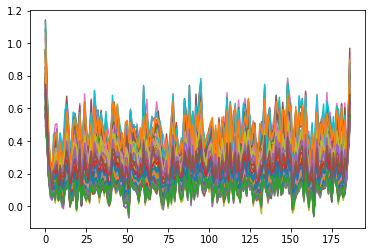

Epoch: 300 | Loss_D: 0.9174878597259521 | Loss_G: 1.2982243299484253 | Time: 09:45:35


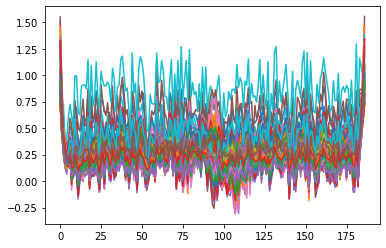

Epoch: 600 | Loss_D: 0.9721221923828125 | Loss_G: 0.9928739070892334 | Time: 09:53:59


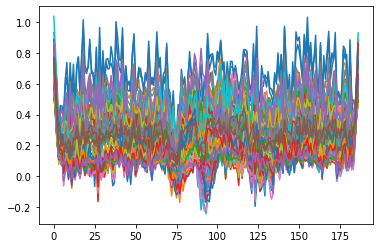

Epoch: 900 | Loss_D: 0.9085727334022522 | Loss_G: 1.4163119792938232 | Time: 10:02:24


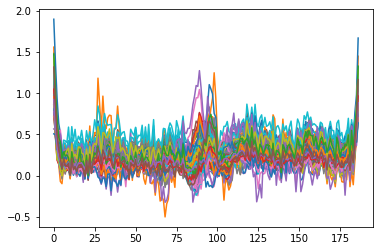

Epoch: 1200 | Loss_D: 0.778026819229126 | Loss_G: 1.3720805644989014 | Time: 10:10:51


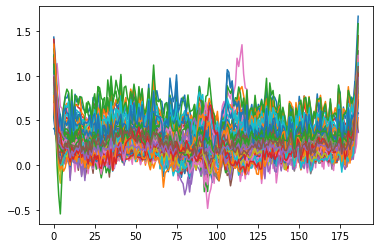

Epoch: 1500 | Loss_D: 0.8990046977996826 | Loss_G: 1.5935558080673218 | Time: 10:19:16


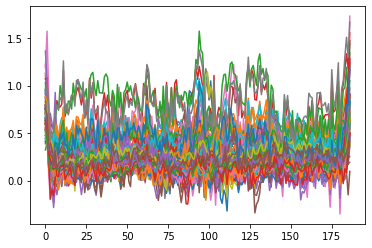

Epoch: 1800 | Loss_D: 0.7766481637954712 | Loss_G: 2.0997376441955566 | Time: 10:27:43


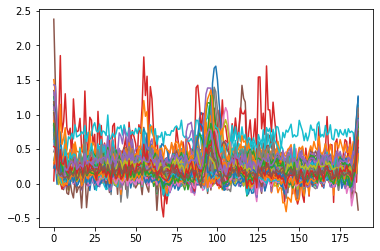

Epoch: 2100 | Loss_D: 0.34151941537857056 | Loss_G: 2.1745798587799072 | Time: 10:36:22


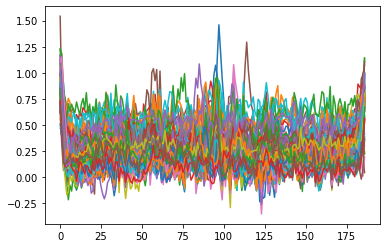

Epoch: 2400 | Loss_D: 0.4887154698371887 | Loss_G: 2.309816360473633 | Time: 10:44:49


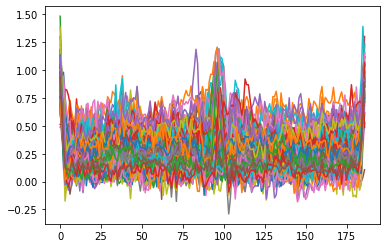

Epoch: 2700 | Loss_D: 0.15094900131225586 | Loss_G: 3.4310386180877686 | Time: 10:53:30


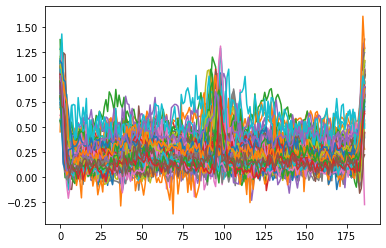

In [56]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=3000,
    label='Atrial Fibrillation'
)
trainer.run()

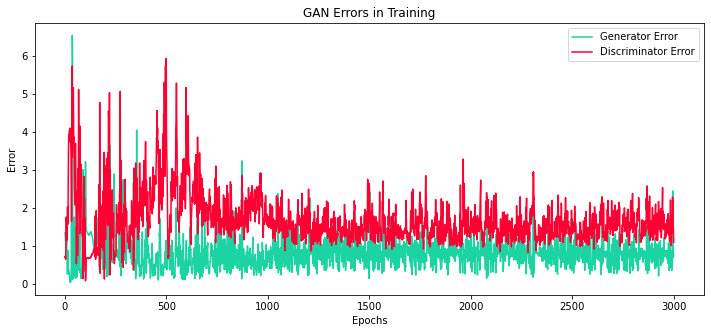

In [14]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

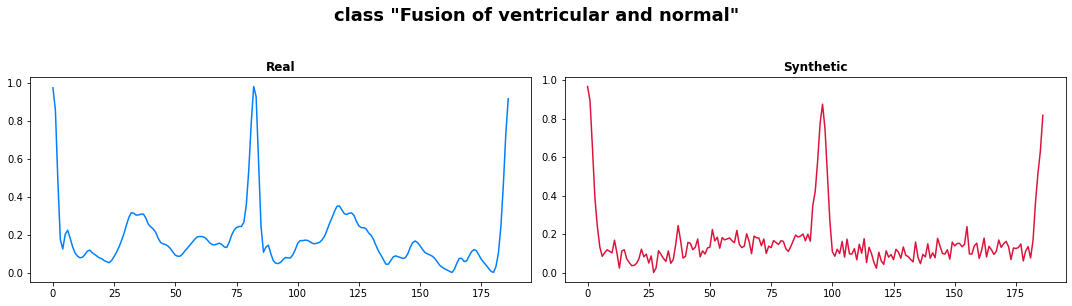

In [64]:
df = pd.read_csv(config.csv_path)
df = df.loc[df['label'] == 'Atrial Fibrillation']

# real signal
N = 1
real_samples =  df.sample(N).values[:, :-2].transpose()

#synthetic signal
fake = trainer.netG(trainer.fixed_noise)
index = np.random.choice(fake.shape[0], N, replace=False) 
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()



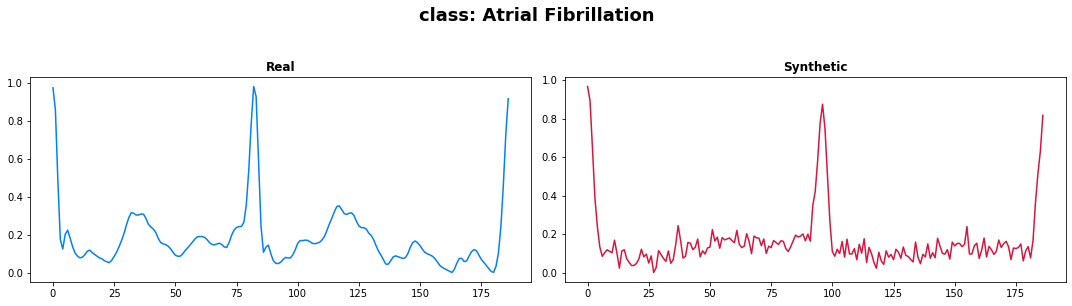

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(real_samples, c='#007FFF')
axs[0].set_title("Real", fontsize= 12, weight="bold")


axs[1].plot(synthetic_samples, c="crimson")
axs[1].set_title("Synthetic", fontsize= 12, weight="bold")

plt.suptitle('class: Atrial Fibrillation', fontsize=18, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig('Fusion_of_ventricular_and_normal.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Fusion_of_ventricular_and_normal.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Conclusion
Since this is a standard process for training a GAN model, we can observe that the Generator produces predominantly dominant signal types.
More specifically, we have a total of 803 signals of the '"Fusion of ventricular and normal"' class, most of which are very similar, and that's what GAN model learned to generate.